In [58]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
dataset_path = "/content/drive/MyDrive/dataset/17Flowers/train"
dataset_path_test = "/content/drive/MyDrive/dataset/17Flowers/test"

img_dt_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


dataset_train = img_dt_generator.flow_from_directory(
    dataset_path,
    subset="training",
    shuffle=True,
    target_size=(224,224),
    batch_size=16
)

dataset_validation = img_dt_generator.flow_from_directory(
    dataset_path,
    subset="validation",
    target_size=(224,224),
    shuffle=False,
)

dataset_test = img_dt_generator.flow_from_directory(
    dataset_path_test,
    target_size=(224,224)
)


print(dataset_train.class_indices)

Found 823 images belonging to 17 classes.
Found 197 images belonging to 17 classes.
Found 340 images belonging to 17 classes.
{'bluebell': 0, 'buttercup': 1, 'coltsfoot': 2, 'cowslip': 3, 'crocus': 4, 'daffodil': 5, 'daisy': 6, 'dandelion': 7, 'fritillary': 8, 'iris': 9, 'lilyvalley': 10, 'pansy': 11, 'snowdrop': 12, 'sunflower': 13, 'tigerlily': 14, 'tulip': 15, 'windflower': 16}


In [60]:
my_model = MobileNetV2(input_shape=(224,224,3),
    weights='imagenet',
    include_top=False,
    pooling="avg"
)

In [50]:
my_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [61]:
for layer in my_model.layers[:-4]:
    layer.trainable = False

In [62]:
model = models.Sequential([

    my_model,

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(17, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [63]:
history = model.fit(dataset_train, batch_size=32, epochs=8, validation_data=dataset_validation)

Epoch 1/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4046 - loss: 2.1109 - val_accuracy: 0.7411 - val_loss: 0.9898
Epoch 2/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8288 - loss: 0.4607 - val_accuracy: 0.8782 - val_loss: 0.3948
Epoch 3/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9055 - loss: 0.2988 - val_accuracy: 0.8173 - val_loss: 0.5563
Epoch 4/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9142 - loss: 0.2504 - val_accuracy: 0.7817 - val_loss: 0.7665
Epoch 5/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9499 - loss: 0.1664 - val_accuracy: 0.8579 - val_loss: 0.5159
Epoch 6/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9339 - loss: 0.2087 - val_accuracy: 0.8629 - val_loss: 0.4759
Epoch 7/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9615 - loss: 0.1500 - val_accuracy: 0.8477 - val_loss: 0.4991
Epoch 8/8
52/52 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9630 - loss: 0.1192 - val_accuracy: 0.8832 - val_loss: 0.4706


In [64]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 17)             │        21,777 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,147,637 (12.01 MB)

 Trainable params: 433,937 (1.66 MB)

 Non-trainable params: 1,845,824 (7.04 MB)

 Optimizer params: 867,876 (3.31 MB)

In [65]:
model.save("model.h5")

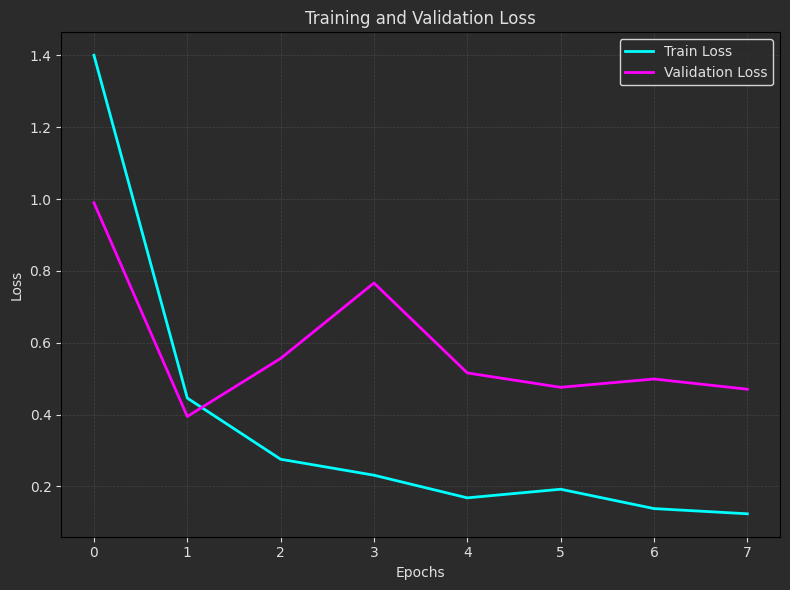

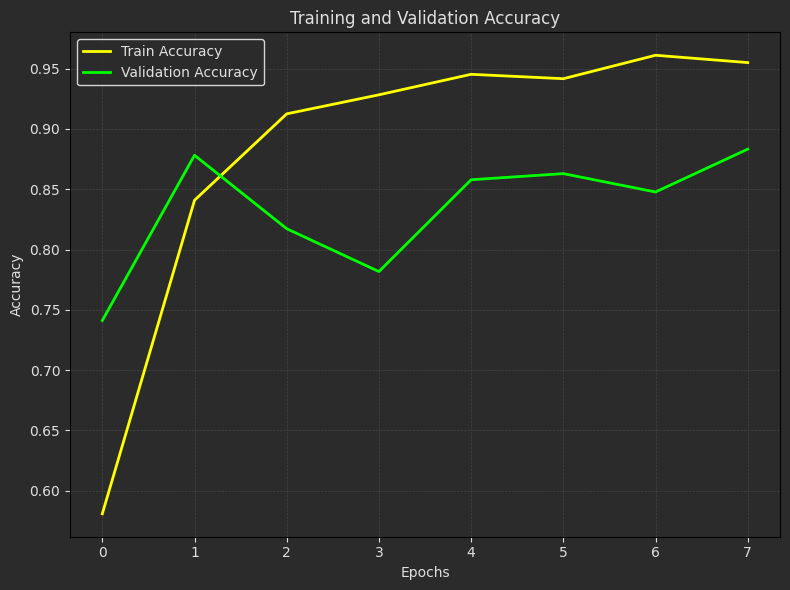

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#2b2b2b')

ax.plot(history.history['loss'], label='Train Loss', color='cyan', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', color='magenta', linewidth=2)

ax.set_title('Training and Validation Loss', color='#e0e0e0')
ax.set_xlabel('Epochs', color='#e0e0e0')
ax.set_ylabel('Loss', color='#e0e0e0')
ax.tick_params(colors='#e0e0e0')
ax.grid(color='#555555', linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_facecolor('#2b2b2b')
ax.legend(facecolor='#2b2b2b', edgecolor='white', labelcolor='#e0e0e0')

plt.tight_layout()



fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#2b2b2b')

ax.plot(history.history['accuracy'], label='Train Accuracy', color='yellow', linewidth=2)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='lime', linewidth=2)

ax.set_title('Training and Validation Accuracy', color='#e0e0e0')
ax.set_xlabel('Epochs', color='#e0e0e0')
ax.set_ylabel('Accuracy', color='#e0e0e0')
ax.tick_params(colors='#e0e0e0')
ax.grid(color='#555555', linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_facecolor('#2b2b2b')
ax.legend(facecolor='#2b2b2b', edgecolor='white', labelcolor='#e0e0e0')

plt.tight_layout()

In [67]:

y_gt = dataset_validation.classes
y_pred = model.predict(dataset_validation)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_gt, y_pred)
conf_matrix

6/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


array([[ 3,  0,  0,  2,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,
         3],
       [ 0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  1,  0,  6,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1],
       [ 0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,
         1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 10,  0,  0,  0,  0,  0,
         0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  

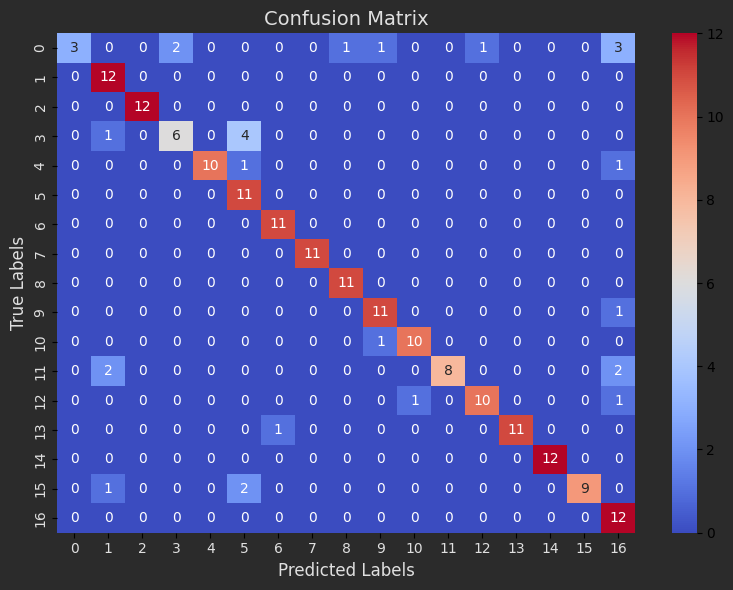

In [68]:
import seaborn as sns

plt.figure(figsize=(8, 6))
fig = plt.gcf()
fig.patch.set_facecolor('#2b2b2b')

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix", fontsize=14, color='#e0e0e0')
plt.xlabel("Predicted Labels", fontsize=12, color='#e0e0e0')
plt.ylabel("True Labels", fontsize=12, color='#e0e0e0')
plt.xticks(color='#e0e0e0')
plt.yticks(color='#e0e0e0')

plt.tight_layout()
plt.show()


In [69]:
test_loss, test_accuracy = model.evaluate(dataset_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 105s 9s/step - accuracy: 0.8738 - loss: 0.4766
Test Loss: 0.44297894835472107, Test Accuracy: 0.8794117569923401


In [70]:

image_test_1 = cv2.imread("/content/image_0203.jpg",1)
image_test_1 = cv2.resize(image_test_1,(224,224))
image_test_1 = image_test_1 / 255.0

test_1 = model.predict(np.array([image_test_1]))
predicted_class = np.argmax(test_1)


if predicted_class == 0:
    print("Bluebell")
elif predicted_class == 1:
    print("Buttercup")
elif predicted_class == 2:
    print("Coltsfoot")
elif predicted_class == 3:
    print("Cowslip")
elif predicted_class == 4:
    print("Crocus")
elif predicted_class == 5:
    print("Daffodil")
elif predicted_class == 6:
    print("Daisy")
elif predicted_class == 7:
    print("Dandelion")
elif predicted_class == 8:
    print("Fritillary")
elif predicted_class == 9:
    print("Iris")
elif predicted_class == 10:
    print("Lilyvalley")
elif predicted_class == 11:
    print("Pansy")
elif predicted_class == 12:
    print("Snowdrop")
elif predicted_class == 13:
    print("sunflower")
elif predicted_class == 14:
    print("Tigerlily")
elif predicted_class == 15:
    print("Tulip")
elif predicted_class == 16:
    print("windflower")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Lilyvalley
